In [189]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from numpy.linalg import inv,det


# Try just a gaussian beam

def Matmulvec(x2,y2,M,x1,y1):

    return (x2*M[0,0] + y2*M[1,0])*x1 + (x2*M[0,1] + y2*M[1,1])*y1

def GaussianPhase(x1,y1,Qinv,k):
    """Determine phase of a gaussian beam

    Parameters
    ----------
    x1 : numpy.ndarray
        detector coordinate in the x direction
    y1 : numpy.ndarray
        detector coordinate in the y direction
    Qinv : 2x2 numpy.ndarray
        inverse of the omplex curvature matrix
    k : scalar
        wavenumber = 2*pi/wavelength

    Returns
    -------
    numpy.ndarray
        phase of an astigmatic gaussian beam on a detector plane
    """
    
    return -1j*k/2 * Matmulvec(x1,y1,Qinv,x1,y1)

def ComputeGouyPhase(Q):

    eigvals = np.linalg.eigvals(Q)
    q1,q2 = eigvals[0],eigvals[1]

    gouy = .5*(np.arctan(np.real(q1)/np.imag(q1)) + np.arctan(np.real(q2)/np.imag(q2)))

    return gouy

def PropagateGaussianPhase(x1,y1,Qinv,k,sys,xd,yd):
    
    A = sys[0:2,0:2]
    B = sys[0:2,2:4]
    C = sys[2:4,0:2]
    D = sys[2:4,2:4]
    
    Q = inv(Qinv)
    Qpinv = (C + D @ Qinv) @ inv(A + B @ Qinv)
    Qp = inv(Qpinv)
    
    gaus = GaussianPhase(x,y,Qpinv,k)

    # Phase from decenter
    demat = np.linalg.inv(Q + np.linalg.inv(A) @ B)

    # Phase from cross term
    crmat = np.linalg.inv(A @ Q + B)

    # phase from decenter parameter
    gaus += -1j*k/2 * Matmulvec(xd,yd,demat,xd,yd) 
    
    # phase from coupling of decenter and position
    gaus += 1j*k * Matmulvec(xd,yd,crmat,x,y) 

    # apply gouy phase shift
    gaus += 1j*ComputeGouyPhase(Qp)

    # amplitude scaling
    amp = 1/np.sqrt((np.linalg.det(A + B @ Qinv)))
    
    return gaus,amp

def PropagateGaussian(x1,y1,Qinv,k,abcd,xd,yd):
    
    gaus,amp = PropagateGaussianPhase(x1,y1,Qinv,k,abcd,xd,yd)
    
    field = amp*np.exp(gaus)
    
    return field

def PropagateTruncatedGaussian(x1,y1,Qinv,k,sys,xd=0,yd=0,angle=np.pi/4,cx=0):
    
    from scipy.special import erfc
    
    A = sys[0:2,0:2]
    B = sys[0:2,2:4]
    C = sys[2:4,0:2]
    D = sys[2:4,2:4]
    
    Binv = inv(B)
    P = Qinv + Binv @ A
    
    npix = x1.shape[0]
    
    x1 = np.ravel(x1)-xd
    y1 = np.ravel(y1)-yd
    position = np.array([x1,y1])
    
    out = RotationMatrix(angle) @ position
    
    x1 = np.reshape(out[0,:],[npix,npix])
    y1 = np.reshape(out[1,:],[npix,npix])
    
    field = PropagateGaussian(x1,y1,Qinv,k,abcd,xd,yd)
    
    # Grab from optical system
    gxx = -1j*k/2 * P[0,0]
    gyy = -1j*k/2 * P[1,1]
    gxy = -1j*k/2 * (P[0,1] + P[1,0])
    gx = 1j*k*(Binv[0,0]*x1 + Binv[0,1]*y1)
    gy = 1j*k*(Binv[1,0]*x1 + Binv[1,1]*y1)
    
    # Converting parameters
    h = gxy/(2*gyy)
    
    # Now do the truncation parameters
    ax = -(gxx - h**2 * gyy)
    bx = -(gx - h*gy)/2
    
    field *= 1/2 * erfc((bx + ax*cx)/np.sqrt(ax))
    
    return field


## Set up a basic optical system and propagate a single truncated gaussian

In [460]:
# set up optical system
wl = 1e-6
npix = 256

# set up detector
dsize = 2 #1.22*wl*(57.6/2.4)*25
x = np.linspace(-dsize/2,dsize/2,npix)
x,y = np.meshgrid(x,x)

# set up gaussian
wo = 100000*wl
zr = np.pi * wo**2 / wl # meters
q  = 1j*zr
qinv = 1/q
k = 2*np.pi/wl


def RotationMatrix(th):
    return np.array([[np.cos(th),-np.sin(th)],
                     [np.sin(th),np.cos(th)]])

# an orthogonal beamlet
Qinv = np.array([[qinv,0],
                 [0,qinv]])

angle = np.pi/4
Qinv = Qinv



d = zr*1e-1
efl = 10*zr*1e14
abcd = np.array([[1,0,d,0],
                 [0,1,0,d],
                 [-1/efl,0,1,0],
                 [0,-1/efl,0,1]])

field = PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx=0,xd=0e-4,yd=0e-4)


## Display cell - we're truncating!

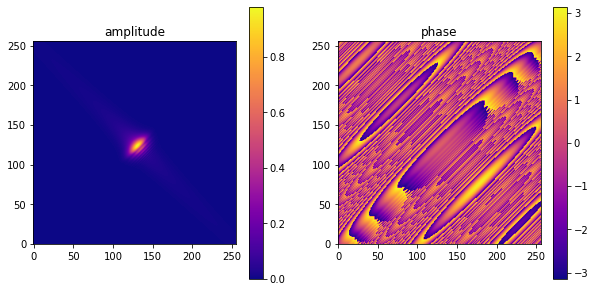

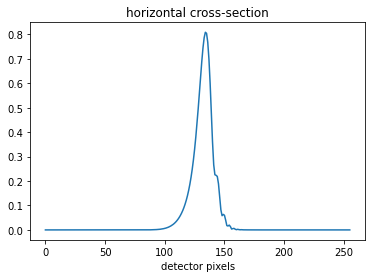

In [461]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(np.abs(field),origin='lower')
plt.title('amplitude')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(np.angle(field),origin='lower')
plt.title('phase')
plt.colorbar()
plt.show()

plt.figure()
plt.title('horizontal cross-section')
plt.plot(np.abs(field)[128,:])
plt.xlabel('detector pixels')
plt.show()

## Let's up the complexity with a quarter-edge aperture by using the gradient-sensing method you came up with for binary apertures

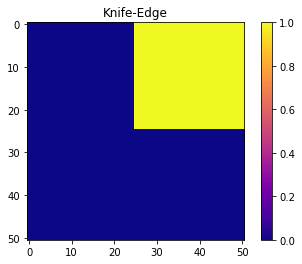

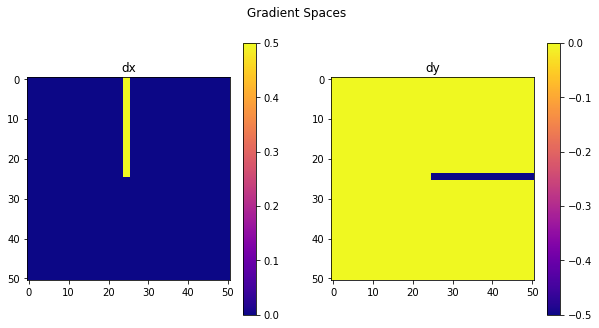

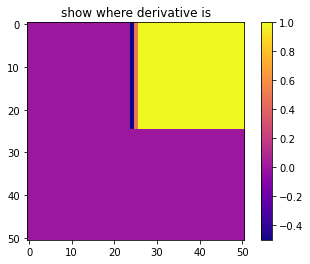

[-0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.
 -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.
 -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.
 -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.   -0.04  0.
 -0.04  0.  ]


In [462]:
# Construct a quarter-Edge that's nbeamlets x nbeamlets
nrays = 51
aperture = np.zeros([nrays,nrays])
x = np.linspace(-1,1,nrays)
x,y = np.meshgrid(x,x)
aperture[x >= 0] = 1
aperture[y >= 0] = 0

plt.figure()
plt.title('Knife-Edge')
plt.imshow(aperture)
plt.colorbar()
plt.show()

# Compute the Gradient of the Aperture
dy,dx = np.gradient(aperture)

plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(dx)
plt.title('dx')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(dy)
plt.title('dy')
plt.colorbar()
plt.show()

# Now we need to grab the POSITIONS of the edge, where is it located?
plt.figure()
plt.title('show where derivative is')
plt.imshow(aperture-dx)
plt.colorbar()
plt.show()

## Grab Positions

# Positions where there is an x truncation
xtrunc_xpos = x[dx != 0]
xtrunc_ypos = y[dx != 0]

# Positions where there is a y truncation
ytrunc_xpos = x[dy != 0]
ytrunc_ypos = y[dy != 0]
print(xtrunc_xpos)

# Positions where there is both an x and y truncation? Need a way of matching the above result but not necessary for the knife-edge
npix = 512
field = np.zeros([npix,npix],dtype='complex128')
x = np.linspace(-1,1,npix)
x,y = np.meshgrid(x,x)
# field[x >= 0] = 1

for i,xval in enumerate(xtrunc_xpos):
    for j,yval in enumerate(xtrunc_ypos):
        
        field += PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx=0,xd=xval,yd=yval,angle=0)
        
for i,xval in enumerate(ytrunc_xpos):
    for j,yval in enumerate(ytrunc_ypos):
        
        field += PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx=0,xd=xval,yd=yval,angle=np.pi/2)    

## Display Cell: It's working!!! Woo!!

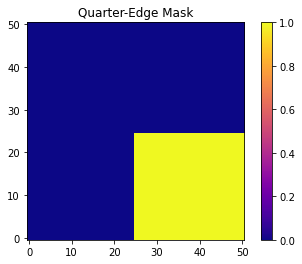

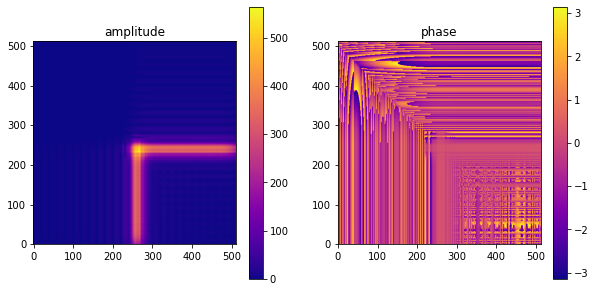

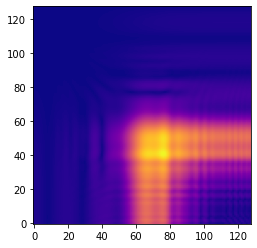

In [464]:
plt.figure()
plt.title('Quarter-Edge Mask')
plt.imshow(aperture,origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(np.abs(field),origin='lower')
plt.title('amplitude')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(np.angle(field),origin='lower')
plt.title('phase')
plt.colorbar()
plt.show()

cut = 64
plt.figure()
plt.imshow(np.abs(field)[int(field.shape[0]/2-cut):int(field.shape[0]/2+cut),int(field.shape[0]/2-cut):int(field.shape[0]/2+cut)],origin='lower')
plt.show()

## Now We should try a square aperture. This relies on using the sign of the coefficients I think, rather than just if it has a nonzero value.
It looks like the coefficient is positive going from dark -> bright, and negative for the reverse

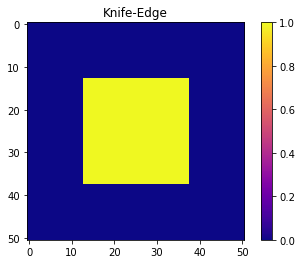

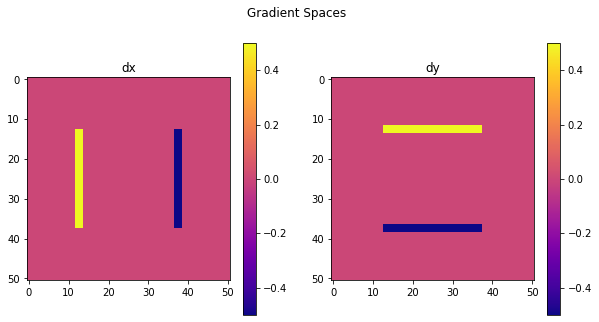

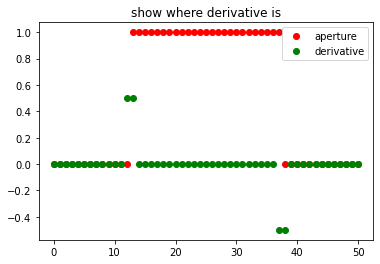

In [334]:
nrays = 51
aperture = np.zeros([nrays,nrays])
x = np.linspace(-1,1,nrays)
x,y = np.meshgrid(x,x)
aperture[x <= 0.5] = 1
aperture[x <= -0.5] = 0
aperture[y >= 0.5] = 0
aperture[y <= -0.5] = 0

plt.figure()
plt.title('Knife-Edge')
plt.imshow(aperture)
plt.colorbar()
plt.show()

# Compute the Gradient of the Aperture
dy,dx = np.gradient(aperture,edge_order=2)

plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(dx)
plt.title('dx')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(dy)
plt.title('dy')
plt.colorbar()
plt.show()

# Now we need to grab the POSITIONS of the edge, where is it located?
plt.figure()
plt.title('show where derivative is')
plt.plot((aperture)[25,:],'ro',label='aperture')
plt.plot((dx)[25,:],'go',label='derivative')
# plt.plot((aperture-dx)[25,:],'bo',label='aperture - derivative')
plt.legend()
plt.show()

## So it looks like there are actually two points where the derivative is nonzero
How do we decide which point to put the gaussian beamlet on? I think it's the interior one. That's a bit more challenging for a sensing problem, so I'm going to start with something hacky:
- 1) Scan along the axis of the derivative for a nonzero point
- 2) Go to the next point, save the position
- 3) Scan along the axis for the next nonzero point and save it
- 4) Repeat steps 1-3

In [329]:
## Grab Positions

# Positions where there is an x truncation
xtrunc_xpos = x[dx != 0]
xtrunc_ypos = y[dx != 0]

# Positions where there is a y truncatio
ytrunc_xpos = x[dy != 0]
ytrunc_ypos = y[dy != 0]
print(xtrunc_xpos)

# Positions where there is both an x and y truncation? Need a way of matching the above result but not necessary for the knife-edge
npix = 256
field = np.zeros([npix,npix],dtype='complex128')
x = np.linspace(-1,1,npix)
x,y = np.meshgrid(x,x)
# field[x >= 0] = 1

# Keep a counter
counter = 0

# V this is not what I thought
for j,yval in enumerate(dx):
    for i,xval in enumerate(dx):
        
        if xval != 0:
            
            if counter%2 == 0:
                
                # This will toggle when you encounter the outer edge, you want the next point
                
                counter += 1
                
                
            else:
                
                #
                
                counter += 1
                
                
            
            
            
            
        
#         field += PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx=0,xd=xval,yd=yval,angle=0)
        
# for i,xval in enumerate(ytrunc_xpos):
#     for j,yval in enumerate(ytrunc_ypos):
        
#         field += PropagateTruncatedGaussian(x,y,Qinv,k,abcd,cx=0,xd=xval,yd=yval,angle=np.pi/2)    

[-0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52 -0.52 -0.48  0.48  0.52
 -0.52 -0.48  0.48  0.52]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [345]:
def ApertureGradient(array):
    
    dx = np.zeros(array.shape)
    dy = np.zeros(array.shape)
    
    # Construct dx
    for yind in range(array.shape[0]):
        for xind in range(array.shape[1]):
            
            dx[yind,xind] = (array[yind,xind]-array[yind,xind-1])
            
    # Construct dy
    for xind in range(array.shape[0]):
        for yind in range(array.shape[1]):
            
            dy[yind,xind] = (array[yind,xind]-array[yind-1,xind])
            

            
    return dx,dy
            

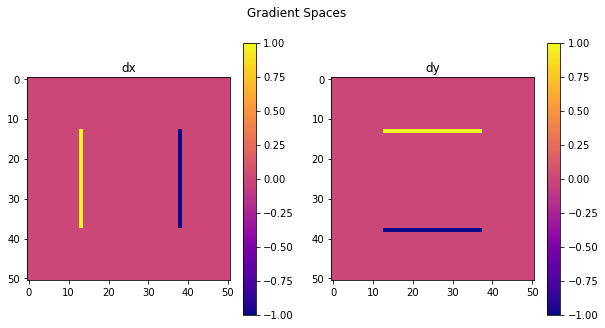

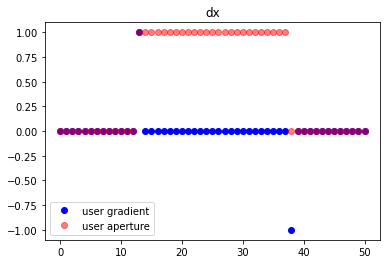

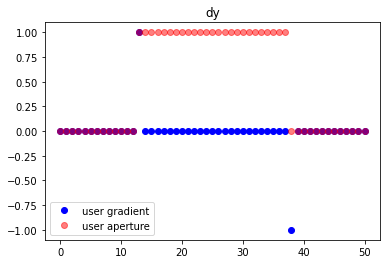

In [350]:
dx,dy = ApertureGradient(aperture)

plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(dx)
plt.title('dx')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(dy)
plt.title('dy')
plt.colorbar()
plt.show()

plt.figure()
plt.title('dx')
plt.plot(dx[25,:],'bo',label='user gradient')
plt.plot(aperture[25,:],'ro',label='user aperture',alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.title('dy')
plt.plot(dy[:,25],'bo',label='user gradient')
plt.plot(aperture[:,25],'ro',label='user aperture',alpha=0.5)
plt.legend()
plt.show()

In [352]:
magnitude = np.sqrt(dx**2 + dy**2)
angle = np.arctan2(dy,dx)

In [471]:
import poppy
import astropy.units as u
wf = poppy.FresnelWavefront(wavelength=1e-6*u.m,beam_radius=1*u.m,npix=100)
hexagon = poppy.HexagonAperture()
aperture = hexagon.get_transmission(wf)


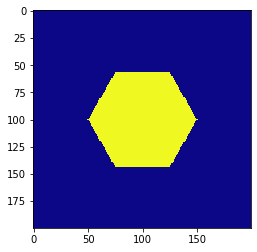

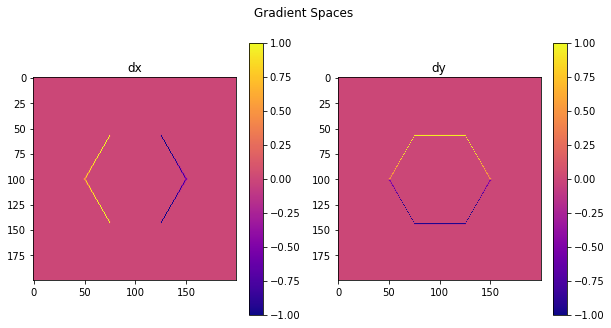

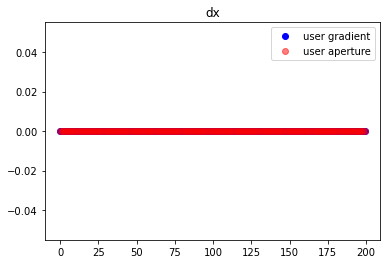

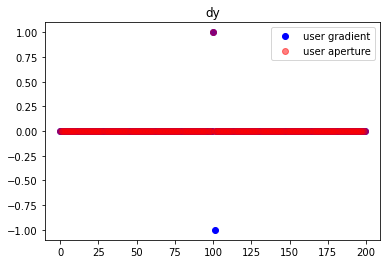

In [472]:
plt.imshow(aperture,interpolation='none')
dx,dy = ApertureGradient(aperture)

plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(dx)
plt.title('dx')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(dy)
plt.title('dy')
plt.colorbar()
plt.show()

plt.figure()
plt.title('dx')
plt.plot(dx[50,:],'bo',label='user gradient')
plt.plot(aperture[50,:],'ro',label='user aperture',alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.title('dy')
plt.plot(dy[:,50],'bo',label='user gradient')
plt.plot(aperture[:,50],'ro',label='user aperture',alpha=0.5)
plt.legend()
plt.show()

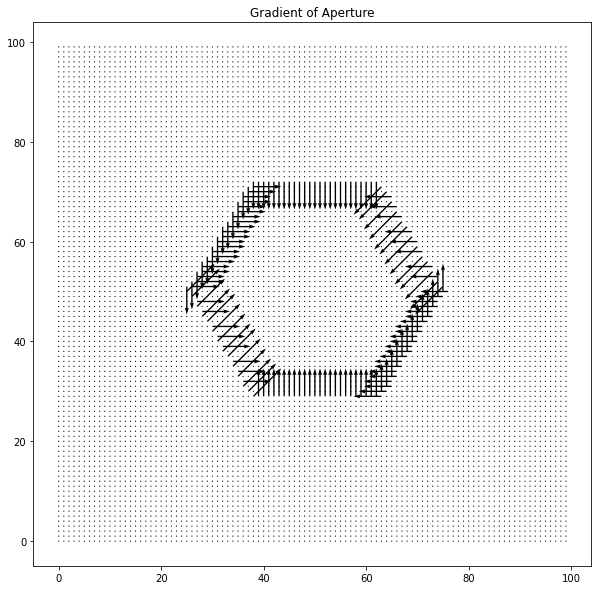

In [441]:
plt.figure(figsize=[10,10])
plt.title('Gradient of Aperture')
plt.quiver(dx,dy,scale=2e1)
plt.show()

## It looks like not all gradient values are created equal! Can we differentiate the cartesian-aligned edges?

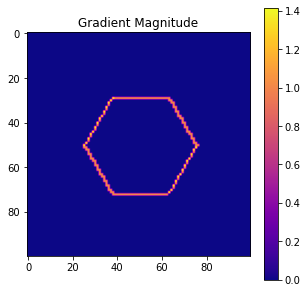

In [442]:
# It appears that 
plt.figure(figsize=[5,5])
plt.title('Gradient Magnitude')
plt.imshow(np.sqrt(dx**2 + dy**2))
plt.colorbar()
plt.show()

## How about trying to use the Magnitude to find the position, and the angle to determine the angle?
Consider that the magnitude is off by one pixel, how do we fix that?
The angle is encouraging! I think that it's with respect to the +x direction and goes counter-clockwise w.r.t. traditional numpy array indexing

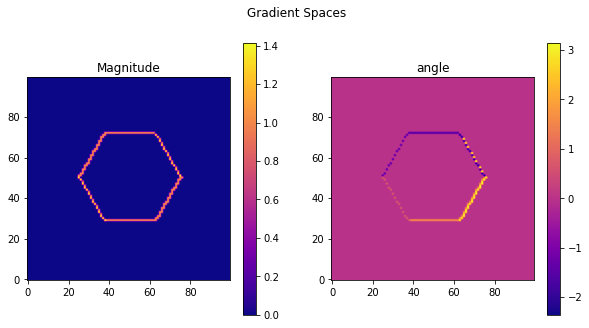

In [443]:
mag = np.sqrt(dx**2 + dy**2)
ang = np.arctan2(dy,dx)
plt.figure(figsize=[10,5])
plt.suptitle('Gradient Spaces')
plt.subplot(121)
plt.set_cmap('plasma')
plt.imshow(mag,origin='lower')
plt.title('Magnitude')
plt.colorbar()
plt.subplot(122)
# plt.set_cmap('bwr')
plt.imshow(ang,origin='lower')
plt.title('angle')
plt.colorbar()
plt.show()

## How do we intelligently sense the far edge?
A hacked way is to just scan across each axis.
- 1) If find first edge, save the index!
- 2) If find next edge, save the index of the one before this
- 3) If find next edge, save the index!

Does this work for non-square apertures?

In [444]:
def ScanSaveApertureEdges(array,xposition,yposition):
    
    "array is the magnitude of the derivative of the aperture"
    
    xtruncated_xpos = []
    xtruncated_ypos = []
    
    ytruncated_xpos = []
    ytruncated_ypos = []
    
    counter = 0
    
    
    # Call this the y index
    for i in range(array.shape[0]):
        
        # Call this the x index
        for j in range(array.shape[1]):
            
            if counter%2 == 0:
            
                if array[i,j] != 0:

                    xtruncated_xpos.append(xposition[i,j])
                    xtruncated_ypos.append(yposition[i,j])

                    counter += 1
                    
            elif counter%2 == 1:
                
                if array[i,j] != 0:
                    
                    xtruncated_xpos.append(xposition[i,j-1])
                    xtruncated_ypos.append(yposition[i,j-1])
                    
                    counter += 1
                    
            else:
                print('Mod Condition Violated')
                
    # Reset the counters and reverse them
    j = 0
    i = 0
    counter = 0
                
    # Call this the x index
    for j in range(array.shape[1]):
        
        # Call this the y index
        for i in range(array.shape[0]):
            
            if counter%2 == 0:
            
                if array[i,j] != 0:

                    ytruncated_xpos.append(xposition[i,j])
                    ytruncated_ypos.append(yposition[i,j])

                    counter += 1
                    
            elif counter%2 == 1:
                
                if array[i,j] != 0:
                    
                    ytruncated_xpos.append(xposition[i-1,j])
                    ytruncated_ypos.append(yposition[i-1,j])
                    
                    counter +=1
                    
            else:
                print('Mod Condition Violated')
                
    return xtruncated_xpos,xtruncated_ypos,ytruncated_xpos,ytruncated_ypos


In [445]:
x = np.linspace(-1,1,100)
x,y = np.meshgrid(x,x)

xtrunc_x,xtrunc_y,ytrunc_x,ytrunc_y = ScanSaveApertureEdges(mag,x,y)

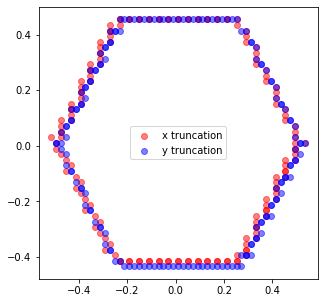

In [446]:
plt.figure(figsize=[5,5])
plt.scatter(xtrunc_x,xtrunc_y,label='x truncation',c='r',alpha=0.5)
plt.scatter(ytrunc_x,ytrunc_y,label='y truncation',c='b',alpha=0.5)
plt.legend()
plt.show()


# I think if we are scanning along the magnitude there's no need to run two for loops, you just loop on position and then save the angle

In [457]:
def ScanSaveApertureEdges(array,xposition,yposition):
    
    "array is the magnitude of the derivative of the aperture"
    
    xtruncated_xpos = []
    xtruncated_ypos = []
    
    ytruncated_xpos = []
    ytruncated_ypos = []
    
    counter = 0
    
    
    # Call this the y index
    for i in range(array.shape[0]):
        
        # Call this the x index
        for j in range(array.shape[1]):
            
            if counter%2 == 0:
            
                if array[i,j] != 0:

                    xtruncated_xpos.append(xposition[i,j])
                    xtruncated_ypos.append(yposition[i,j])
                    ytruncated_xpos.append(xposition[i,j])
                    ytruncated_ypos.append(yposition[i,j])
                    

                    counter += 1
                    
            elif counter%2 == 1:
                
                if array[i,j] != 0:
                    
                    xtruncated_xpos.append(xposition[i,j])
                    xtruncated_ypos.append(yposition[i,j])
                    ytruncated_xpos.append(xposition[i,j])
                    ytruncated_ypos.append(yposition[i,j])
                    
                    counter += 1
                    
            else:
                print('Mod Condition Violated')
                
   
                
    return xtruncated_xpos,xtruncated_ypos,ytruncated_xpos,ytruncated_ypos



In [458]:
x = np.linspace(-1,1,100)
x,y = np.meshgrid(x,x)

xtrunc_x,xtrunc_y,ytrunc_x,ytrunc_y = ScanSaveApertureEdges(mag,x,y)

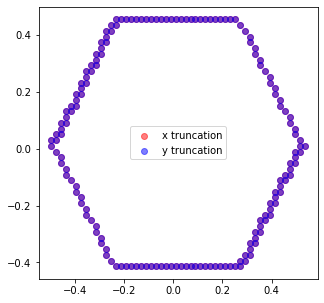

In [459]:
plt.figure(figsize=[5,5])
plt.scatter(xtrunc_x,xtrunc_y,label='x truncation',c='r',alpha=0.5)
plt.scatter(ytrunc_x,ytrunc_y,label='y truncation',c='b',alpha=0.5)
plt.legend()
plt.show()

## Getting ready to throw in the towel on magnitude-based edge detection. Do we even need to do gradients?
I can see an argument if we have non-uniform amplitudes, but idk how much it actually matters. Let's try *subaperture scanning*. Doubled number of pixels

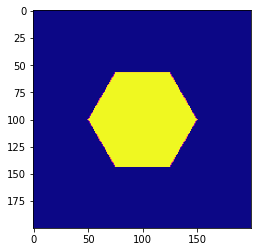

In [473]:
def SubApertureScanForTruncation(ap):
    
    """ap = aperture file"""
    
    for indx,val in np.ndenumerate(ap):
        
        # Conditions that we are on a transmissive pixel and the subpixel array is not all ones, and that we aren't on a corner
        if val == 1.0 and np.mean(ap[indx-1:indx+1,indx-1:indx+1]) < 1.0 and np.mean(ap[indx-1:indx+1,indx-1:indx+1]) < 1.0:
            
            
    
    return

plt.imshow(aperture,interpolation=None)

## These are the types of subaperture scans we expect

In [479]:
a = np.array([[1,0,0],
              [0,0,0],
              [0,0,0]])

b = np.array([[1,1,0],
              [1,0,0],
              [0,0,0]])

c = np.array([[1,1,1],
              [1,0,0],
              [1,0,0]])

d = np.array([[1,1,0],
              [1,0,0],
              [1,0,0]])

e = np.array([[1,0,0],
              [1,0,0],
              [1,0,0]])

f = np.array([[1,1,1],
              [1,0,0],
              [1,1,1]])

print(np.mean(a))
print(np.mean(b))
print(np.mean(c))
print(np.mean(d))
print(np.mean(e))
print(np.mean(f))

0.1111111111111111
0.3333333333333333
0.5555555555555556
0.4444444444444444
0.3333333333333333
0.7777777777777778
